# Cleaning the Google dataset  
The Google local review dataset is huge.
Most of the businesses in it aren't even in Chicago so we will first make sure they are out of the dataset.
From these filtered businesses, we can easily filter the reviews by only keeping those who relate to a Chicago place.

In [4]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
import gzip

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '16g'),  # find
                                   ('spark.driver.memory','16g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

First we clean the loose json format that isn't recognized by pandas or spark.  
We used the method [recommended from the dataset](https://cseweb.ucsd.edu/~jmcauley/datasets.html)

In [19]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [ ]:
places = parse('resources/google/places.json.gz')
places_df = pd.DataFrame.from_records(places)

In [ ]:
reviews = parse('resources/google/reviews.json.gz')
reviews_df = pd.DataFrame.from_records(reviews)

In [ ]:
reduced_place_df = places_df[['name', 'price', 'address', 'gPlusPlaceId', 'gps']]
reduced_place_df.to_parquet('resources/google/places.parquet')
reviews_df.to_parquet('resources/google/reviews.parquet')

Then we load the data in spark to do some cleaning on the location.

In [5]:
places = pd.read_parquet('resources/google/places.parquet')

The GPS location isn't practical in its current form so we explod it in a latitude and longitude column.

In [6]:
places = places[places.gps.notnull()]
gps_s = places.gps
places['lat'] = gps_s.map(lambda x: x[0])
places['long'] = gps_s.map(lambda x: x[1])
places = places.drop('gps', axis=1)

We only keep the places in Chicago using the Chicago geojson.

In [7]:
from shapely.geometry import shape, Point
import json

with open('resources/geojsons/chicago-city.geojson') as f0:
    chicago_border = json.load(f0)

chicago_shape = shape(chicago_border['features'][0]['geometry'])

def is_in_chicago(lng_lat):
    point = Point(lng_lat[0], lng_lat[1])    
    return chicago_shape.contains(point)

In [8]:
places = places[places[['long', 'lat']].apply(lambda x: is_in_chicago(x), axis=1)]
places.head(5)

,name,price,address,gPlusPlaceId,lat,long
119,Einstein Bros Bagels,$$$,"[30 N La Salle St #100e, Chicago, IL 60602]",106913331862145825724,41.882712,-87.632876
579,Home Inspection Star Inc.,None,"[Belmont Cragin, Chicago, IL]",110218752920671431928,41.878113,-87.629798
721,American Jewelry & Pawn,None,"[3216 N Kimball Ave, Chicago, IL 60618]",105748380737912333722,41.939812,-87.712875
834,Simmons Pro Shop,None,"[2147 Irving Park Rd, Chicago, IL 60618]",113127123035046799359,41.953963,-87.683065
999,Chicago's Home of Chicken & Waffles,$$,"[3947 S King Dr, Chicago, IL 60653]",104594164305625743160,41.822511,-87.616570


Adding the community/wards/zip codes to have more means of grouping the businesses

In [9]:
with open('resources/geojsons/chicago-community.geojson') as f:
    communities = json.load(f)
    
with open('resources/geojsons/chicago-wards.geojson') as f:
    wards = json.load(f)

with open('resources/geojsons/chicago-zip.geojson') as f:
    zips = json.load(f)
    
def find_border(lng_lat, geojson, property_name):
    point = Point(lng_lat[0], lng_lat[1])
    for feature in geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties'][property_name]
    return 'Not found'

In [10]:
places['ward'] = places[['long', 'lat']].apply(lambda x: find_border(x, wards, 'ward'), axis=1)
places['zip'] = places[['long', 'lat']].apply(lambda x: find_border(x, zips, 'zip'), axis=1)
places['community'] = places[['long', 'lat']].apply(lambda x: find_border(x, communities, 'community'), axis=1)

In [11]:
places.head(5)

,name,price,address,gPlusPlaceId,lat,long,ward,zip,community
119,Einstein Bros Bagels,$$$,"[30 N La Salle St #100e, Chicago, IL 60602]",106913331862145825724,41.882712,-87.632876,42,60602,LOOP
579,Home Inspection Star Inc.,None,"[Belmont Cragin, Chicago, IL]",110218752920671431928,41.878113,-87.629798,4,60604,LOOP
721,American Jewelry & Pawn,None,"[3216 N Kimball Ave, Chicago, IL 60618]",105748380737912333722,41.939812,-87.712875,35,60618,AVONDALE
834,Simmons Pro Shop,None,"[2147 Irving Park Rd, Chicago, IL 60618]",113127123035046799359,41.953963,-87.683065,47,60618,NORTH CENTER
999,Chicago's Home of Chicken & Waffles,$$,"[3947 S King Dr, Chicago, IL 60653]",104594164305625743160,41.822511,-87.616570,3,60653,GRAND BOULEVARD


We clean the price to have a numeric value instead of a string.

In [12]:
places.price.value_counts()

$$$    2837
$$     2599
$       436
         56
Name: price, dtype: int64

In [13]:
places.isnull().sum()

name               0
price           9591
address            0
gPlusPlaceId       0
lat                0
long               0
ward               0
zip                0
community          0
dtype: int64

A lot of places have a null price se we decide to keep them as this.

In [14]:
price_map = {'$$$': 3, '$$': 2, '$': 1, '': 0, None: None}
places.price = places.price.map(lambda x: price_map.get(x))

In [15]:
places.price.value_counts()

3.0    2837
2.0    2599
1.0     436
0.0      56
Name: price, dtype: int64

In [16]:
places.gPlusPlaceId = places.gPlusPlaceId.astype('str')

That's better and easier to manipulate!

We will comeback later to this dataset to ensure we only have restaurants/grocery stores.

### Cleaning the reviews dataset

We will remove all reviews rating a business out of Chicago.

In [17]:
reviews = pd.read_parquet('resources/google/reviews.parquet')
reviews.count()

rating            11453845
reviewerName      11453845
reviewText         7920730
categories        10487697
gPlusPlaceId      11453845
unixReviewTime    10601852
reviewTime        10601852
gPlusUserId       11453845
dtype: int64

In [18]:
reviews = reviews[['rating', 'reviewText', 'gPlusPlaceId', 'reviewTime', 'gPlusUserId', 'categories']]
reviews.head(3)

,rating,reviewText,gPlusPlaceId,reviewTime,gPlusUserId,categories
0,3.0,Chất lượng tạm ổn,108103314380004200232,"Jul 1, 2013",100000010817154263736,[Giải Trí - Café]
1,5.0,Wc si temiz duzenli..,102194128241608748649,"Jul 21, 2012",100000013500285534661,[Turkish Cuisine]
2,5.0,何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗,101409858828175402384,"Jan 25, 2014",100000021336848867366,"[Fishing, Pond Fish Supplier, Seafood Market]"


In [19]:
chicago_gPlusPlaceIds = places.gPlusPlaceId
reviews.gPlusPlaceId = reviews.gPlusPlaceId.astype('str')
reviews = reviews[reviews.gPlusPlaceId.isin(chicago_gPlusPlaceIds)]
reviews.count()

rating          116083
reviewText       92438
gPlusPlaceId    116083
reviewTime      109427
gPlusUserId     116083
categories      109101
dtype: int64

Doing this removed about 99% our our dataset but 100000 reviews may be enough to perform analysis.  
We want to see the time distribution to be sure it matches our food inspection dataset.

In [20]:
reviews = reviews[reviews.reviewTime.notnull()]
reviews.reviewTime = pd.to_datetime(reviews.reviewTime)

In [21]:
min_time = reviews.reviewTime.min()
max_time = reviews.reviewTime.min()
print('Earliest time: {}'.format(reviews.reviewTime.min()))
print('Furthest time: {}'.format(reviews.reviewTime.max()))

Earliest time: 1990-12-30 00:00:00
Furthest time: 2014-03-28 00:00:00


<BarContainer object of 15 artists>

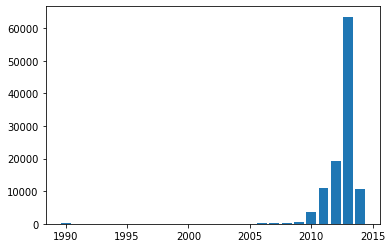

In [22]:
years = reviews.reviewTime.map(lambda x: x.year).value_counts()
plt.bar(x=years.index, height=years.values)

We have a lot more more reviews in 2011 to 2014 we a huge peak in 2013.  
It may be interesting to only focus on these years.

In [23]:
reviews = reviews[reviews.reviewTime.map(lambda x: x.year).isin(range(2011,2015))]

In [24]:
reviews.dtypes

rating                 float64
reviewText              object
gPlusPlaceId            object
reviewTime      datetime64[ns]
gPlusUserId             object
categories              object
dtype: object

Saving the wole thing to avoid recomputing.

In [25]:
places.to_parquet('resources/google/places_clean.parquet')
reviews.to_parquet('resources/google/reviews_clean.parquet')

# Comparing inspection fail rate and average google rating by ward  
We want to see if there may be a correlation between user ratings and food inspection result.  
What's the rating difference between a high pass ward and a ward with a high fail rate?

In [105]:
places = pd.read_parquet('resources/google/places_clean.parquet')
reviews = pd.read_parquet('resources/google/reviews_clean.parquet')
inspections = pd.read_parquet('resources/extended_dataset.parquet')

First we want to compute the average score of a business from the Google dataset.

In [106]:
places.gPlusPlaceId = places.gPlusPlaceId.astype('str')
reviews.gPlusPlaceId = reviews.gPlusPlaceId.astype('str')

In [107]:
med_ratings = reviews[['gPlusPlaceId', 'rating']].groupby(by='gPlusPlaceId').median().rename(columns={'rating': 'med_rating'}).reset_index()
avg_ratings = reviews[['gPlusPlaceId', 'rating']].groupby(by='gPlusPlaceId').mean().rename(columns={'rating': 'avg_rating'}).reset_index()

In [108]:
ratings = places.merge(med_ratings, left_on='gPlusPlaceId', right_on='gPlusPlaceId')
ratings = ratings.merge(avg_ratings, left_on='gPlusPlaceId', right_on='gPlusPlaceId')

In [109]:
ward_google_ratings = ratings[['ward', 'med_rating', 'avg_rating']].groupby(by='ward').mean()
ward_google_ratings.head(5)

,med_rating,avg_rating
ward,,
1,4.247438,4.156468
10,3.821970,3.755748
11,4.176259,4.073104
12,3.904321,3.836449
13,4.030000,3.949823


And then the average pass/fail/... rating of inspections.  
Note that we need first to reduce the time range as the Chicago dataset is more spread out compared to the Google one.  

In [110]:
min_date = reviews['reviewTime'].min()
max_date = reviews['reviewTime'].max()
print('We will range between {} and {}'.format(min_date, max_date))
inspections_in_time_range = inspections[(inspections['Inspection Date'] > min_date) & (inspections['Inspection Date'] < max_date)]

We will range between 2011-01-01 00:00:00 and 2014-03-28 00:00:00


In [111]:
only_inspections = inspections_in_time_range.copy()[~inspections_in_time_range['Re-inspection']][['Ward', 'Results']].rename(columns={'Ward': 'ward', 'Results': 'result'})
result_map = {'Pass': 'pass', 'Fail': 'fail', 'Pass w/ Conditions': 'pass_cond', 'Out of Business': 'oob', 'No Entry': 'no_entry'}

for key in result_map.keys():
    only_inspections[result_map.get(key)] = only_inspections.result == key
    
only_inspections = only_inspections.drop('result', axis=1)

We create all the usefull pass/fail rate statistics for each ward.

In [112]:
ward_inspection_ratings = only_inspections.groupby(by='ward').mean()
ward_inspection_ratings.head(5)

,pass,fail,pass_cond,oob,no_entry
ward,,,,,
1,0.491061,0.266389,0.079261,0.131108,0.032181
10,0.507132,0.223455,0.085578,0.126783,0.050713
11,0.613707,0.194185,0.069574,0.107996,0.014538
12,0.565976,0.243184,0.057797,0.114504,0.018539
13,0.654397,0.173824,0.067485,0.098160,0.006135


In [113]:
merged_ratings = ward_inspection_ratings.merge(ward_google_ratings, on='ward')
merged_ratings.corr('spearman')

,pass,fail,pass_cond,oob,no_entry,med_rating,avg_rating
pass,1.000000,-0.701128,-0.571188,-0.624394,0.004754,-0.045282,-0.051717
fail,-0.701128,1.000000,0.164466,0.150156,-0.239376,-0.315438,-0.297383
pass_cond,-0.571188,0.164466,1.000000,0.124994,-0.070636,0.356447,0.349148
oob,-0.624394,0.150156,0.124994,1.000000,0.142569,0.066699,0.059880
no_entry,0.004754,-0.239376,-0.070636,0.142569,1.000000,0.241969,0.255990
med_rating,-0.045282,-0.315438,0.356447,0.066699,0.241969,1.000000,0.992989
avg_rating,-0.051717,-0.297383,0.349148,0.059880,0.255990,0.992989,1.000000


Interestingly, we observe a small negative correlation between the google rating and the inspection fail rate while there is no correlation between having a good goole rate and a passing an inspection.  
It shows that places failing the inspections are also often the ones being badly rated. Maybe the cause of the bad rate may come from the badly kept restaurant.

## Finding chicago food places and their reviews in the google dataset

In [114]:
inspections_pos = inspections[['Latitude', 'Longitude']].apply(lambda x: "{0:.4f} {1:.4f}".format(x[0], x[1]), axis=1).unique()
places_pos = places[['lat', 'long']].apply(lambda x: "{0:.4f} {1:.4f}".format(x[0], x[1]), axis=1).unique()

In [115]:
print(inspections_pos.size)
print(places_pos.size)

16284
14051


In [116]:
intersection_pos = set(places_pos).intersection(set(inspections_pos))
len(intersection_pos)

1818

If we round the latitude/longitude to only 4 decimals (100m precision), we find 1818 common locations.  
We will use these to see if there is a correlation by restaurant instead of by ward/community.

In [117]:
places_common = places.copy()
places_common['gps'] = places[['lat', 'long']].apply(lambda x: "{0:.4f} {1:.4f}".format(x[0], x[1]), axis=1)
places_common = places_common[places_common.gps.isin(intersection_pos)]
places_common.head()

,name,price,address,gPlusPlaceId,lat,long,ward,zip,community,gps
579,Home Inspection Star Inc.,NaN,"[Belmont Cragin, Chicago, IL]",110218752920671431928,41.878113,-87.629798,4,60604,LOOP,41.8781 -87.6298
4262,Number 1 Chop Suey,3.0,"[4307 W Irving Park Rd, Chicago, IL 60641]",115699310654267306421,41.953411,-87.735982,45,60641,IRVING PARK,41.9534 -87.7360
7614,China Phoenix Restaurant,NaN,"[2459 W Madison St, Chicago, IL 60612]",118150923611903564108,41.881035,-87.688732,27,60612,NEAR WEST SIDE,41.8810 -87.6887
12432,Hon Kee Restaurant,2.0,"[1064 W Argyle St, Chicago, IL 60640]",105951989958300540067,41.973358,-87.657391,48,60640,UPTOWN,41.9734 -87.6574
14775,Sport Clips Chicago- Wrigley,NaN,"[3452 N Clark St, Chicago, IL 60657]",109393307658739866852,41.944864,-87.654852,44,60657,LAKE VIEW,41.9449 -87.6549


In [118]:
places_ids = places_common.gPlusPlaceId
filtered_ratings = reviews[reviews.gPlusPlaceId.isin(places_ids)][['gPlusPlaceId', 'rating']].groupby(by='gPlusPlaceId').mean().rename(columns={'rating': 'avg_rating'}).reset_index()
location_ratings = places_common.merge(filtered_ratings, left_on='gPlusPlaceId', right_on='gPlusPlaceId')
location_ratings = location_ratings.drop(['name', 'lat', 'long', 'zip', 'community', 'address', 'gPlusPlaceId', 'ward', 'price'], axis=1)
location_ratings.head()

,gps,avg_rating
0,41.8781 -87.6298,5.000000
1,41.9534 -87.7360,4.000000
2,41.8810 -87.6887,4.000000
3,41.9734 -87.6574,4.200000
4,41.9449 -87.6549,3.833333


In [119]:
inspections_common = inspections.copy()
inspections_common = inspections_common[(inspections_common['Inspection Date'] > min_date) & (inspections_common['Inspection Date'] < max_date)]
inspections_common['gps'] = inspections[['Latitude', 'Longitude']].apply(lambda x: "{0:.4f} {1:.4f}".format(x[0], x[1]), axis=1)
inspections_common = inspections_common[inspections_common.gps.isin(intersection_pos)]
inspections_common = inspections_common.drop(['Inspection ID', 'AKA Name', 'License #', 'Address', 'Zip', 'Precinct', 'Violations',\
                                              'Community', 'Neighborhood', 'Latitude', 'Longitude'], axis=1)

result_map = {'Pass': 'pass', 'Fail': 'fail', 'Pass w/ Conditions': 'pass_cond', 'Out of Business': 'oob', 'No Entry': 'no_entry'}
for key in result_map.keys():
    inspections_common[result_map.get(key)] = inspections_common.Results == key
    
inspections_common = inspections_common.drop('Results', axis=1)
inspections_common.head()

,DBA Name,Facility Type,Risk,Inspection Date,Inspection Type,Re-inspection,Ward,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,gps,pass,fail,pass_cond,oob,no_entry
113921,BJ'S MARKET & BAKERY,Restaurant,High,2014-03-27,Complaint,False,8,"[30, 32, 33, 34, 35, 36, 41]",7,0,0,7,41.7359 -87.5858,True,False,False,False,False
113942,TAQUERIA UPTOWN,Restaurant,High,2014-03-27,Canvass,False,48,"[12, 30, 33, 38]",4,1,0,3,41.9837 -87.6599,False,False,True,False,False
113951,COCORO,Restaurant,High,2014-03-27,Canvass,False,42,"[6, 9, 12, 31, 32, 33, 35, 38, 41, 43]",10,3,0,7,41.8944 -87.6343,False,False,True,False,False
113953,The Indian Garden Restaurant,Restaurant,High,2014-03-27,Canvass,False,42,"[30, 35, 43]",3,0,0,3,41.8933 -87.6215,True,False,False,False,False
113975,DUNKIN DONUTS BASKIN ROBBINS,Restaurant,High,2014-03-27,Canvass,False,36,"[32, 33, 34, 40]",4,0,0,4,41.9457 -87.7766,True,False,False,False,False


In [120]:
merge = inspections_common.groupby(by='gps').mean().merge(location_ratings, left_on='gps', right_on='gps')
merge.head(5)

,gps,Re-inspection,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,pass,fail,pass_cond,oob,no_entry,avg_rating
0,41.6524 -87.5470,0.000000,5.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.0,3.40
1,41.6528 -87.5473,0.142857,2.714286,0.000000,0.142857,2.571429,0.571429,0.285714,0.000000,0.142857,0.0,4.25
2,41.6530 -87.5410,0.333333,4.000000,0.000000,0.333333,3.666667,0.666667,0.333333,0.000000,0.000000,0.0,5.00
3,41.6554 -87.5470,0.000000,6.666667,0.333333,0.000000,6.333333,0.666667,0.000000,0.333333,0.000000,0.0,5.00
4,41.6566 -87.5974,0.250000,6.000000,0.250000,0.250000,5.500000,0.500000,0.250000,0.250000,0.000000,0.0,2.00


In [121]:
merge.corr('spearman')

,Re-inspection,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,pass,fail,pass_cond,oob,no_entry,avg_rating
Re-inspection,1.000000,0.327815,0.424071,0.774914,0.179013,-0.340308,0.835062,0.051197,-0.149449,-0.041208,-0.027660
Nb Violations,0.327815,1.000000,0.372659,0.410640,0.964340,0.054727,0.227012,0.283509,-0.368879,-0.113148,-0.048943
Nb Violations of high severity,0.424071,0.372659,1.000000,0.380009,0.201663,-0.364888,0.337496,0.520527,-0.046971,-0.094130,-0.033711
Nb Violations of medium severity,0.774914,0.410640,0.380009,1.000000,0.227376,-0.429215,0.700594,0.286907,-0.131085,-0.051566,-0.031630
Nb Violations of low severity,0.179013,0.964340,0.201663,0.227376,1.000000,0.198359,0.089628,0.190704,-0.370978,-0.093100,-0.047443
pass,-0.340308,0.054727,-0.364888,-0.429215,0.198359,1.000000,-0.406599,-0.364524,-0.474520,-0.214976,-0.022596
fail,0.835062,0.227012,0.337496,0.700594,0.089628,-0.406599,1.000000,-0.086045,-0.139611,-0.011037,0.010180
pass_cond,0.051197,0.283509,0.520527,0.286907,0.190704,-0.364524,-0.086045,1.000000,-0.061722,-0.065046,-0.027924
oob,-0.149449,-0.368879,-0.046971,-0.131085,-0.370978,-0.474520,-0.139611,-0.061722,1.000000,-0.019772,0.034326
no_entry,-0.041208,-0.113148,-0.094130,-0.051566,-0.093100,-0.214976,-0.011037,-0.065046,-0.019772,1.000000,0.008633


If we do the analysis on a per location basis, the correlation isn't there anymore.  
Unfortunately, we have to drop the idea that average google rating is correlated with the inspection fail rate.

## Are google ratings linked to inspection frequency?  
We take back our previous dataset to see if the number of inspection may correlate with the google rating.

In [122]:
inspections_per_ward = reduced_inspections.copy()[['ward']]
inspections_per_ward['inspection'] = 1
number_of_inspections_per_ward = inspections_per_ward.groupby(by='ward').sum()
number_of_inspections_per_ward.head()

,inspection
ward,
1,1678
10,631
11,963
12,917
13,489


We normalize this result using the number of licenses in each ward.

In [123]:
licenses_per_ward = inspections_in_time_range.copy()[~inspections_in_time_range['Re-inspection']][['Ward', 'License #']].rename(columns={'Ward': 'ward'})
licenses_per_ward = licenses_per_ward.groupby(by='ward').nunique()[['License #']].rename(columns={'License #': 'license_count'})
licenses_per_ward.head()

,license_count
ward,
1,712
10,301
11,373
12,377
13,192


In [124]:
normalized_inspections_per_ward = number_of_inspections_per_ward.copy()
normalized_inspections_per_ward.inspection = number_of_inspections_per_ward.inspection / licenses_per_ward.license_count
normalized_inspections_per_ward.head()

,inspection
ward,
1,2.356742
10,2.096346
11,2.581769
12,2.432361
13,2.546875


In [125]:
ward_google_ratings.head()

,med_rating,avg_rating
ward,,
1,4.247438,4.156468
10,3.821970,3.755748
11,4.176259,4.073104
12,3.904321,3.836449
13,4.030000,3.949823


In [126]:
ward_google_ratings.merge(normalized_inspections_per_ward, left_on='ward', right_on='ward').corr()

,med_rating,avg_rating,inspection
med_rating,1.000000,0.992603,-0.023025
avg_rating,0.992603,1.000000,-0.019947
inspection,-0.023025,-0.019947,1.000000


Again, no correlation between the number of inspections and the google ratings